<img src="../../thu_sigs_logo.png" alt="清华深研院-横" style="zoom:50%;" />

In [1]:
#| default_exp svm.handy_crafted.linear

In [ ]:
#|hide
from thu_big_data_ml.help import plt

In [ ]:
#|hide
# autoreload
%load_ext autoreload
%autoreload 2
%load_ext rich

本文是[更高效的支持向量机算法实现及其在手写数字识别中的应用](./00svm.html)系列文章第02篇——手动实现SGD优化的软间隔线性SVM。

In [ ]:
#| exporti
from scholarly_infrastructure.logging.nucleus import logger, print
from sklearn.datasets import load_digits, fetch_openml
from thu_big_data_ml.svm.infra import process_sklearn_dataset_dict, compute_classification_metrics

In [27]:
dataset_dict_uci_digits = load_digits(as_frame=False)
X_train, X_val, X_test, y_train, y_val, y_test, train_set, val_set, test_set, data_module, categories = process_sklearn_dataset_dict(dataset_dict_uci_digits, 'all')
dataset_dict_full_mnist = fetch_openml("mnist_784", as_frame=True)
X_train_full, X_val_full, X_test_full, y_train_full, y_val_full, y_test_full, train_set_full, val_set_full, test_set_full, data_module_full, categories_full = process_sklearn_dataset_dict(dataset_dict_full_mnist, 'all')

(1797, 64) float32 (1797,) int64 [0 1 2 3 4 5 6 7 8 9]
1293 144 360
(70000, 784) float32 (70000,) int64 [0 1 2 3 4 5 6 7 8 9]
50400 5600 14000


### 实现 Hinge Loss+SGD 版本的 Soft Margin Linear SVM

我们现在来实现与`from sklearn.linear_model import SGDClassifier`等价的 SVM，但是我们基于PyTorch实现，在GPU上面运行，期望能在大型数据集上比sklearn的实现快。

#### Hinge Loss 二分类实现

首先回顾二分类情况下，李航《统计学习方法》131页的优化目标：

$$
\min_{w, b} \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+ + \lambda \lVert w \rVert^2
$$

李航随即给出了证明，证明这个无约束最优化问题等价于优化软间隔线性支持向量机的原始问题。我感觉上面的式子有点丑，莫名其妙地引入了没有物理意义的超参数$\lambda$, 让读者无法与软间隔问题中的$C$联系起来。所以我们使用李航证明中用来说明这两个问题等效性的式子:

$$
\min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+
$$

其中 $\xi_i = \left[ 1 - y_i(w \cdot x_i + b) \right]_+ $ 是松弛变量，$[]_+$ 自动地让松弛变量满足了约束。

我们现在就可以用 PyTorch 实现这个 二分类情况下的 Hinge Loss了。

注意，在下面的代码中我们不会去实现$\frac{1}{2} \lVert w \rVert^2$! 

因为在实际PyTorch项目中，这个是写在 Optimizer的 weight decay里面的。 1/2 其实和 C 、学习率等 只是相对比例关系。

这是因为 PyTorch 的设计哲学中，loss 函数的输入就是 logits 和 labels，不会包括模型的参数，这样才能把逻辑解耦开来。

所以如果我们在loss就实现 l2 regularization，是很麻烦而且没有必要的。

Optimizer 有权限访问到 model 的参数，所以我们待会可以精确控制，只对 weight 而非 bias 做 l2 regularization，从而满足 SVM 的要求。


In [3]:
#| exports
import torch
import torch.nn as nn
from fastcore.all import store_attr

In [4]:
#| exports
class BinaryHingeLoss(nn.Module):
    """
    Binary Hinge Loss. 
    For SVM, 
    $$
    \min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+
    $$
    we compute 
    $$
    C \sum_{i=1}^N \left[ 1 - y_i(w \cdot x_i + b) \right]_+
    $$
    """
    def __init__(self, C=1.0, 
                 squared = False, 
                 margin = 1.0,
                 ):
        super().__init__()
        store_attr() # 保存参数到实例变量中

    def forward(self, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor:
        functional_margin = y_true * y_pred_logits # 函数间隔
        how_small_than_required_margin = self.margin - functional_margin
        xi = torch.clamp(how_small_than_required_margin, min=0) # 计算 xi 也就是 松弛变量
        if self.squared:
            xi = xi ** 2
        return self.C * xi.sum()


其中 `squared` 参数表示是否使用 squared hinge loss。
什么叫做 squared hinge loss 呢？我们做过理论作业，李航《统计学习方法》153页例题 7.3 提到了 (但是书上没有给出Reference)
$$
\min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i^2
$$ 
来取代
$$
\min_{w, b}  \frac{1}{2} \lVert w \rVert^2 + C \sum_{i=1}^N \xi_i
$$ 
其实上面那个式子就是 squared hinge loss。

In [5]:
from fastcore.test import test_eq

In [6]:
# 尝试一下
critierion = BinaryHingeLoss(margin=1, C=1, squared=False)
y_pred_logits = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y_true = torch.tensor([1.0, -1.0, 1.0])
test_eq(critierion(y_pred_logits, y_true).item(), 1-(-1.0)*2.0) # 第二个样本分类错误，函数间隔为 -2， 差了 3

#### Hinge Loss 多分类实现

现在我们已经成功实现 BinaryHingeLoss， 接下来我们要考虑 多分类情况下 要如何变化。

参考 

- https://lightning.ai/docs/torchmetrics/stable/classification/hinge_loss.html
- https://pytorch.org/docs/stable/generated/torch.nn.MultiMarginLoss.html

按照我们上文 理论回顾 一节说的，有两类方法。首先是直接法，具体来说 [Crammer and Singer在论文中](https://jmlr.csail.mit.edu/papers/volume2/crammer01a/crammer01a.pdf) 提出， 对于每一个样本$x_i, y_i, t_i $ (y_i 是 one hot vector, t_i 是 标签，假如是第k类也就是$t_i = k $，$y_i^{t_i} = 1, y_i^{k!=t_i} = 0$), 使用这一个公式来作为 多分类的 Hinge Loss
$$
L_i = \left[ 1 - (\hat{y_i}^{t_i} - \max_{k \neq t_i} \hat{y_i}^k)) \right]_+
$$
其中 $\hat{y_i}^k = (w^k \cdot x_i + b^k)$ 是针对第k个类的那一个SVM($w^k, b^k$表示)预测出来的值，不是函数间隔哦，没有乘$y_i^k$。

而间接法则是使用 one vs all(a.k.a., rest) 来计算 hinge loss。（one vs one 比较少见）

具体而言，首先 $t_i = k $，$y_i^{t_i} = 1, y_i^{k!=t_i} = -1$, $\hat{y_i}^k = (w^k \cdot x_i + b^k)$ 表示 是否为 第k个类。
对于每一个样本i，对于每一个样本k都能计算出一个binary loss：

$$L_i^k = \left[ 1 - y_i^k (w^k \cdot x_i + b^k) \right]_+ $$

相当于同时在训练K个分类器，所以这些loss都可以加在一起，反向传播训练对于$w^k, b^k$独立操作。

所以推导一下，如果每一个 $1 - y_i^k (w^k \cdot x_i + b^k)$ 都 $\gt 0$ 就相当于

$$L_i = \sum_{k=1}^{K} L_i^k \approx \left[ K - (\hat{y_i}^{t_i} - \sum_{k \neq t_i} \hat{y_i}^k)) \right]_+ $$

但是并不是都>0的，没法这样进去推导，所以还是得老老实实相加。

理论清晰之后，现在我们开始实现代码：

In [7]:
#| exports
from fastcore.all import patch
from typing import Literal

In [8]:
#| exports

Strategy = Literal['crammer_singer', 'one_vs_all']
class MultiClassHingeLoss(nn.Module):
    """MultiClassHingeLoss"""
    def __init__(self, C=1.0, 
                 squared = False, 
                 margin = 1.0,
                 strategy: Strategy = 'crammer_singer',
                #  *args, **kwargs
                 ):
        super().__init__()
        store_attr()
        self.binary_critieria = None
    def forward(self, y_pred_logits:torch.Tensor, 
                y_true:torch.Tensor # 并非 one hot 编码，而是 int/long 类型 的 label
                )->torch.Tensor:
        if self.strategy == 'crammer_singer':
            return self.forward_crammer_singer(y_pred_logits, y_true)
        elif self.strategy == 'one_vs_all':
            return self.forward_one_vs_all(y_pred_logits, y_true)
        else:
            raise ValueError(f"Invalid strategy: {self.strategy}")
    def forward_one_vs_all(self, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor:
        num_of_classes = y_pred_logits.size(1)
        if self.binary_critieria is None:
            self.binary_critieria = nn.ModuleList([
                BinaryHingeLoss(C=self.C, squared=self.squared, margin=self.margin)
                for _ in range(num_of_classes)
                ])
        losses = []
        for k, critierion in enumerate(self.binary_critieria):
            y_true_binary = 2 * (y_true == k) - 1 # 转换为 -1/1 编码、
            y_pred_that_class = y_pred_logits[:, k]
            loss = critierion(y_pred_that_class, y_true_binary)
            losses.append(loss)
        return sum(losses)
    def forward_crammer_singer(self, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor: ...

In [9]:
#| exports
import torch

In [10]:
#| exports
def get_max_values_without_true(y_pred_logits, y_true):
    """
    获取去掉y_true对应元素后，y_pred_logits每行的最大值。

    参数:
    y_pred_logits: torch.Tensor, 形状为 (N, K)
    y_true: torch.Tensor, 形状为 (N,)

    返回:
    torch.Tensor, 形状为 (N,), 去掉y_true对应元素后每行的最大值
    """
    # 将y_true转换为适当的索引格式
    indices = y_true.unsqueeze(1).expand_as(y_pred_logits)

    # 创建一个与y_pred_logits形状相同的掩码，真实标签位置为False，其余为True
    mask = torch.ones_like(y_pred_logits, dtype=torch.bool)
    mask.scatter_(1, indices, False)

    # 使用掩码来排除y_true对应的列，并计算每一行的最大值
    max_values = y_pred_logits[mask].view(y_pred_logits.size(0), -1).max(dim=1)[0]

    return max_values

我们调用已经实现的`BinaryHingeLoss`来实现`forward_one_vs_all`。

为了方便实现 `forward_crammer_singer` 方法，首先我们实现一个辅助函数，

注意 PyTorch中的索引有广播机制，我们刚才编程的时候遇到这个问题，实现了一阵才正确实现逻辑。

下面的代码是说明这个问题的最小重现单元，它的运行结果可能超出你的预期，所以编程的时候我们刚才特别注意了这一点。

In [11]:
# 
y_pred = torch.ones(2, 10)
y_true = torch.zeros(2).to(int)
y_pred[:, y_true] # 很多人以为会是 [1, 1], 实际输出 [[1., 1.], [1., 1.]]

tensor([[1., 1.],
        [1., 1.]])

测试一下函数正确性

In [12]:
y_pred_logits = torch.tensor([[1, 2, 3, 4, 5],
                             [6, 7, 8, 9, 10],
                             [11, 12, 13, 14, 15],
                             [16, 17, 18, 19, 20]], dtype=torch.float)
y_true = torch.tensor([4, 4, 4, 4])

# 函数调用
max_values = get_max_values_without_true(y_pred_logits, y_true)
max_values

tensor([ 4.,  9., 14., 19.])

正确。
现在我们继续实现 `MultiClassHingeLoss.forward_crammer_singer`, fastcore 提供 `patch` 扩展了 Python 的能力，可以支持 Mixin 风格的软件编程。

In [13]:
#| exports
@patch
def forward_crammer_singer(self:MultiClassHingeLoss, y_pred_logits:torch.Tensor, y_true:torch.Tensor)->torch.Tensor:
    """L_i = \left[ 1 - (\hat{y_i}^{t_i} - \max_{k \neq t_i} \hat{y_i}^k)) \right]_+"""
    batch_size, num_classes = y_pred_logits.size()
    y_true_one_hot = torch.eye(num_classes).to(y_pred_logits.device)[y_true]
    
    # 计算真实类别的预测值
    y_true_logits = (y_pred_logits * y_true_one_hot).sum(dim=1)
    # y_true_logits = y_pred_logits[:, y_true]

    max_other_logits = get_max_values_without_true(y_pred_logits, y_true)
    
    functional_margin_differences = (y_true_logits - max_other_logits)
    
    # 计算hinge loss
    xi = torch.clamp(self.margin - functional_margin_differences, min=0)
    
    if self.squared:
        xi = xi ** 2
    return self.C * xi.sum()

现在我们简单测试一下上面实现的两个Loss是否计算正确，与理论公式一样。

In [14]:
y_pred_logits = torch.tensor([[0.5, -0.5], [-0.5, 0.5]])
y_true = torch.tensor([0, 1])
critierion = MultiClassHingeLoss(strategy="crammer_singer")
loss = critierion(y_pred_logits, y_true)
loss

tensor(0.)

上面的结果是正确的，因为 自己这个类别的 预测值 是 0.5, 其他类别的最大预测值是 -0.5, 比它大1, 正好是margin，所以loss为0

In [15]:
critierion = MultiClassHingeLoss(strategy="one_vs_all")
loss = critierion(y_pred_logits, y_true)
loss

tensor(2.)

上面的结果也是正确的，这两个数据都是 正确的那个类 自己只有0.5的值，不到1， 而错误的类不到-1，所以有正负类两个样本各有0.5的loss，一共为2。

以上我们实现的Loss在真实情况中会使用哪个组合呢？这也是个值得探讨的问题。

对于多类别的情况，[论文](https://www.csie.ntu.edu.tw/~cjlin/papers/l2mcsvm/l2mcsvm.pdf) 详细研究了  crammer_singer 方法 +  squared hinge loss 的有效性，所以这两者是可以结合的。 

#### SVM 模型与优化算法实现

在 crammer_singer 方法 和 one vs all 的情况下，SVM的参数$w, b$的大小是 `(n_features, n_classes), (n_classes,)`，这与多分类的感知机、Linear+Softmax是一样的。

In [ ]:
#| exports
from overrides import override
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT, OptimizerLRScheduler
import torch.optim as optim
import lightning as L

In [ ]:
#| exports
# lightning imports

In [17]:
#| exports
class HingeSupportVectorClassifier(L.LightningModule):
    def __init__(self, 
                #  model related
                 input_dim, num_classes,  
                #  optimization related
                 learning_rate=0.01, weight_decay=0.5, 
                 optimizer_type = optim.SGD, 
                #  loss related
                 C: float = 1,
                    squared: bool = False,
                    margin: float = 1,
                    strategy: Strategy = 'crammer_singer',
                #  experiment related
                 experiment_index=0,  
                 ):
        super().__init__()
        self.save_hyperparameters()
        L.seed_everything(experiment_index)
        self.model = nn.Linear(input_dim, num_classes)
        self.loss_fn = MultiClassHingeLoss()
        
        self.example_input_array = torch.randn(1, input_dim)
        self.dummy_inputs = dict(input_ids=self.example_input_array) # for opendelta and huggingface
        self.automatic_optimization = True
        # 评价策略
        self.evaluation_steps_outputs = dict()
        
    @override
    def forward(self, image_tensor:torch.Tensor, *args, **kwargs)-> torch.Tensor:
        """
        Returns:
            torch.Tensor: the predicted functional margin to each class's decision hyperplane   
        """
        return self.model(image_tensor)
    
    def predict_geometric_margin(self, image_tensor:torch.Tensor)->torch.Tensor:
        w_norm_each_line = torch.norm(self.model.weight, dim=1)
        return torch.clamp(self(image_tensor) / w_norm_each_line, min=0)
    
    def predict_class(self, image_tensor:torch.Tensor)->torch.Tensor:
        return torch.argmax(self(image_tensor), dim=1)

    def forward_loss(self, image_tensor: torch.Tensor, label_tensor:torch.Tensor)->torch.Tensor:
        logits = self(image_tensor)
        return self.loss_fn(logits, label_tensor)
        
    @override
    def training_step(self, batch, batch_idx=None, *args, **kwargs)-> STEP_OUTPUT:
        loss = self.forward_loss(*batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

In [ ]:
from namable_classify.infra import print_model_pretty

In [ ]:
test_model = HingeSupportVectorClassifier(28*28, 10)
test_model.print_model_pretty()
y_pred_logits =test_model(test_model.example_input_array)
test_model.predict_class(test_model.example_input_array)
test_model.predict_geometric_margin(test_model.example_input_array)
# y_pred_logits
# test_model.loss_fn(y_pred_logits, torch.tensor([0]))
test_model.forward_loss(test_model.example_input_array, torch.tensor([0]))

Seed set to 0


Mon 2024-11-18 20:38:01.629617

INFO     ╭─────────────────────── Model Tree for HingeSupportVectorClassifier ────────────────────────╮ ]8;id=271493;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=536110;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#72\72]8;;\
         │ root                                                                                       │            
         │ └── model (Linear) weight:[10, 784] bias:[10]                                              │            
         ╰────────────────────────────────────────────────────────────────────────────────────────────╯            

tensor(1.4472, grad_fn=<MulBackward0>)

我们定义好了 loss 和 model（w与b的参数，以及决策超平面如何用于决策）。
现在我们要定义训练算法。

首先我们来首先一下 上文我们提到的sklearn使用的 Leon Bottou optimal learning rate。从现代深度学习的角度来看，Leon Bottou 本质上是提出了一个 learning rate scheduler。

参照 [Leon Bottou 的SVM网站](https://leon.bottou.org/projects/sgd),
他对学习率的规划如下

SGD

$$
\eta_t = \frac{\eta_0}{(1 + \lambda \eta_0 t)}
$$

ASGD

$$
\eta_t = \frac{\eta_0}{(1 + \lambda \eta_0 t)^{0.75}}
$$

其中对于第一个形式，是否是一个特殊的[指数/gamma 衰减的学习率]？(https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html)。
$$
{\eta}_{t+1} = \frac{\eta_0}{(1 + \lambda \eta_0 (t+1) )} 
$$

$$
\gamma = \frac{{\eta}_{t+1}}{\eta_t} = \frac{1}{1+\frac{1}{t + \frac{1}{\lambda \eta_0}}} 
$$
答案是否定的，因为 $\gamma$ 推导出来不是和t无关的常数。 所以Leon Bottou不是 gamma衰减的特殊情况。

In [19]:
#| exports
scheduler_lmd_leon_bottou_sgd = lambda epoch, init_lr=0.1, lmd=0.001: init_lr / (1+ lmd*init_lr*epoch)
scheduler_lmd_leon_bottou_asgd = lambda epoch, init_lr=0.1, lmd=0.001: init_lr / (1+ lmd*init_lr*epoch)**0.75


不要忘了刚才还有 $\frac{1}{2} ||w||^2$ 项， 需要特别注意 bias $b$ 没有被decay。[博客](https://discuss.pytorch.org/t/weight-decay-only-for-weights-of-nn-linear-and-nn-conv/114348)提到，尽管很多论文都指出了分开这两者的weight decay的重要性，但是在torch中实现这一点还是有一定的难度的。

In [20]:
#| exports
def separate_weight_decay(model:nn.Module, weight_decay: float, otherwise_set_to:float=0.0, verbose:bool=False):
    decay = list() # 不能使用 set，由于Pytorch优化器需要顺序
    no_decay = list()
    for name, param in model.named_parameters():
        do_weight_decay = 'weight' in name
        if verbose:
            print(f'{name} should do weight decay? {do_weight_decay}')
        if do_weight_decay:
            decay.append(param)
        else:
            no_decay.append(param)
    # return decay, no_decay
    return [
                dict(params=decay, weight_decay=weight_decay), 
                dict(params=no_decay, weight_decay=otherwise_set_to)
            ]

In [21]:
test_model = HingeSupportVectorClassifier(10, 10)
weight_decay = 0.001
separate_weight_decay(test_model, weight_decay)
pass

Seed set to 0


In [22]:
#| exports
@override    
@patch
def configure_optimizers(self:HingeSupportVectorClassifier) -> OptimizerLRScheduler:
    init_lr = self.hparams.learning_rate
    # lmd = self.hparams.weight_decay / self.hparams.C 
    lmd = self.hparams.weight_decay # 需要考证，Leon Bottou的lamda 是什么情况下推导的。

    weight_decay = self.hparams.weight_decay
    
    if self.hparams.optimizer_type == torch.optim.ASGD:
        optimizer = torch.optim.ASGD(
            # self.parameters(), 
            separate_weight_decay(self, weight_decay), 
                                    lr=init_lr,  # 刚才 save_hyperparameters() 保存了，这是为了方便是使用 Lightning 调学习率
                                    # weight_decay = self.hparams.weight_decay, # 李航书上的 hinge loss的第一项
                                    ) 
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                lr_lambda=lambda epoch: scheduler_lmd_leon_bottou_asgd(epoch, init_lr, lmd))
    elif self.hparams.optimizer_type == torch.optim.SGD:
        optimizer = torch.optim.SGD(
            # self.parameters(), 
            separate_weight_decay(self, weight_decay), 
                                    lr=init_lr,
                                    # weight_decay=self.hparams.weight_decay
                                    )
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
                lr_lambda=lambda epoch: scheduler_lmd_leon_bottou_sgd(epoch, init_lr, lmd))
    else:
        return self.hparams.optimizer_type(self.parameters(), lr=init_lr, weight_decay=self.hparams.weight_decay) # 只 return optimizer
        
    return ([optimizer], [scheduler])


最后我们补上评价指标

In [ ]:
#| exports
from namable_classify.infra import append_dict_list, ensure_array
from typing import Any
import numpy as np

In [24]:
#| exports
@patch
def on_evaluation_epoch_start(self:HingeSupportVectorClassifier, stage:str=""):
    self.evaluation_steps_outputs = dict()
    self.evaluation_steps_outputs[f'{stage}_batch_probs'] = []
    self.evaluation_steps_outputs[f'{stage}_label_tensor'] = []
    # self.evaluation_steps_outputs[f'{stage}_batch_preds'] = []
        
@patch
def evaluation_step(self:HingeSupportVectorClassifier, batch, batch_idx=None, stage:str="", *args: Any, **kwargs: Any) -> STEP_OUTPUT:
    image_tensor, label_tensor = batch
    batch_probs = self(image_tensor)
    # batch_preds = self.predict_class(image_tensor)
    append_dict_list(self.evaluation_steps_outputs, f'{stage}_batch_probs', ensure_array(batch_probs))
    append_dict_list(self.evaluation_steps_outputs, f'{stage}_label_tensor', ensure_array(label_tensor))
    # append_dict_list(self.evaluation_steps_outputs, f'{stage}_batch_preds', ensure_array(batch_preds))
    batch_loss = self.loss_fn(batch_probs, label_tensor)
    self.log(f"{stage}_loss", batch_loss, prog_bar=True)
    return batch_loss
        
@patch
def on_evaluation_epoch_end(self:HingeSupportVectorClassifier, stage:str=""):
    # https://github.com/Lightning-AI/pytorch-lightning/discussions/9845
    # labels = self.lit_data.classes
    # labels = list(range(self.lit_data.num_of_classes))
    labels = list(range(self.hparams.num_classes))
    # labels = None
    # print(labels)
    # stack 是 new axis， concat是existing axis
    all_pred_probs = np.concatenate(self.evaluation_steps_outputs[f'{stage}_batch_probs'])
    all_label_tensor = np.concatenate(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
    # all_preds = np.concatenate(self.evaluation_steps_outputs[f'{stage}_batch_preds'])
    # logger.debug(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
    # logger.debug(all_label_tensor)
    eval_dict = compute_classification_metrics(all_label_tensor, all_pred_probs, 
                                            #    logits_to_prob=False, 
                                                logits_to_prob=True, 
                                            labels=labels)
    eval_dict = {f"{stage}_{k}": v for k,v in eval_dict.items()}
    self.log_dict(eval_dict)
    self.evaluation_steps_outputs.clear()

@override
@patch
def on_validation_epoch_start(self:HingeSupportVectorClassifier):
    return self.on_evaluation_epoch_start(stage="val")

@override
@patch
def on_test_epoch_start(self:HingeSupportVectorClassifier):
    return self.on_evaluation_epoch_start(stage="test")

@override
@patch
def on_validation_epoch_end(self:HingeSupportVectorClassifier):
    return self.on_evaluation_epoch_end(stage="val")

@override
@patch
def on_test_epoch_end(self:HingeSupportVectorClassifier):
    return self.on_evaluation_epoch_end(stage="test")

@override
@patch
def validation_step(self:HingeSupportVectorClassifier, batch, batch_idx=None, *args, **kwargs):
    return self.evaluation_step(batch, batch_idx, stage="val")

@override
@patch
def test_step(self:HingeSupportVectorClassifier, batch, batch_idx=None, *args, **kwargs):
    return self.evaluation_step(batch, batch_idx, stage="test")


In [28]:
input_dim = X_val.shape[1]
num_of_classes = len(categories)
input_dim, num_of_classes

(64, 10)

In [29]:
get_cls_task = lambda: HingeSupportVectorClassifier(input_dim, num_of_classes, 
                                        learning_rate=1,
                                        weight_decay=0.5, 
                                        optimizer_type=torch.optim.ASGD, C=1, squared=True, margin=1, 
                                        strategy="crammer_singer", experiment_index=0)
cls_task = get_cls_task()
cls_data = data_module
# cls_data = data_module_full

Seed set to 0


#### SVM 训练与评价

In [30]:
from thu_big_data_ml.help import runs_path
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary, LearningRateMonitor, LearningRateFinder, BatchSizeFinder

In [31]:
trainer = L.Trainer(default_root_dir=runs_path, 
                    enable_checkpointing=True, 
                    enable_model_summary=True, 
                    # num_sanity_val_steps=2, # 防止 val 在训了好久train才发现崩溃
                    callbacks=[
                        EarlyStopping(monitor="val_acc1", mode="max", check_finite=True, 
                                      patience=5, 
                                      check_on_train_epoch_end=False,  # check on validation end
                                      verbose=True),
                        ModelSummary(max_depth=3),
                        # LearningRateFinder(), 
                        # BatchSizeFinder(), 
                        LearningRateMonitor(logging_interval="epoch")
                               ]
                    # , fast_dev_run=True
                    # , limit_train_batches=10, 
                    # limit_val_batches=5
                    , accelerator="gpu", devices=1, strategy="auto"
                    )

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
#| eval: false
trainer.fit(cls_task, datamodule=cls_data)
val_res = trainer.validate(cls_task, datamodule=cls_data)
test_res = trainer.test(cls_task, datamodule=cls_data)
pass

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:58:49.020341

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=262674;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=953938;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

INFO: 
  | Name    | Type                | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------------
0 | model   | Linear              | 650    | train | [1, 64]  | [1, 10]  
1 | loss_fn | MultiClassHingeLoss | 0      | train | ?        | ?        
-------------------------------------------------------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sat 2024-11-16 00:58:49.057947

INFO                                                                                           ]8;id=945989;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=154100;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
           | Name    | Type                | Params | Mode  | In sizes | Out sizes                                 
         -------------------------------------------------------------------------------                           
         0 | model   | Linear              | 650    | train | [1, 64]  | [1, 10]                                   
         1 | loss_fn | MultiClassHingeLoss | 0      | train | ?        | ?                                         
         -------------------------------------------------------------------------------                           
         650       Trainable params                                                                                
         0         Non-trainable params                                                                            
         650       Total params                                                                                    
         0.003     Total estimated model params size (MB)                                                          
         2         Modules in train mode                                                                           
         0         Modules in eval mode                                                                            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc1 improved. New best score: 0.514


Sat 2024-11-16 00:58:52.534348

INFO     Metric val_acc1 improved. New best score: 0.514                                      ]8;id=942500;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py\early_stopping.py]8;;\:]8;id=891786;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py#273\273]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc1 improved by 0.229 >= min_delta = 0.0. New best score: 0.743


Sat 2024-11-16 00:58:55.733727

INFO     Metric val_acc1 improved by 0.229 >= min_delta = 0.0. New best score: 0.743          ]8;id=105592;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py\early_stopping.py]8;;\:]8;id=370977;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py#273\273]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc1 improved by 0.007 >= min_delta = 0.0. New best score: 0.750


Sat 2024-11-16 00:59:01.783794

INFO     Metric val_acc1 improved by 0.007 >= min_delta = 0.0. New best score: 0.750          ]8;id=957361;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py\early_stopping.py]8;;\:]8;id=214410;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py#273\273]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc1 improved by 0.111 >= min_delta = 0.0. New best score: 0.861


Sat 2024-11-16 00:59:09.920693

INFO     Metric val_acc1 improved by 0.111 >= min_delta = 0.0. New best score: 0.861          ]8;id=546678;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py\early_stopping.py]8;;\:]8;id=273145;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py#273\273]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_acc1 improved by 0.042 >= min_delta = 0.0. New best score: 0.903


Sat 2024-11-16 00:59:14.194501

INFO     Metric val_acc1 improved by 0.042 >= min_delta = 0.0. New best score: 0.903          ]8;id=960489;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py\early_stopping.py]8;;\:]8;id=14723;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py#273\273]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_acc1 did not improve in the last 5 records. Best score: 0.903. Signaling Trainer to stop.


Sat 2024-11-16 00:59:26.505406

INFO     Monitored metric val_acc1 did not improve in the last 5 records. Best score: 0.903.  ]8;id=744754;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py\early_stopping.py]8;;\:]8;id=864912;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/early_stopping.py#273\273]8;;\
         Signaling Trainer to stop.                                                                                

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:59:27.127571

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=641620;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=517553;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_acc1          │    0.8541666865348816     │
│         val_acc10         │            1.0            │
│         val_acc2          │    0.9513888955116272     │
│         val_acc20         │            1.0            │
│         val_acc3          │    0.9652777910232544     │
│         val_acc5          │    0.9791666865348816     │
│   val_balanced_accuracy   │    0.8519047498703003     │
│      val_cohen_kappa      │    0.8378465175628662     │
│          val_f1           │    0.8545861840248108     │
│      val_hinge_loss       │    0.29842936992645264    │
│       val_log_loss        │    0.9072062373161316     │
│         val_loss          │     263.0315856933594     │
│   val_matthews_corrcoef   │    0.8427900671958923     │
│       val_precision       │    0.8835164904594421     │
│        val_recall         │    0.8519047498703003     │
│        val_roc_auc        │    0.9750232100486755     │
└───────────────────────────┴───────────────────────────┘

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:59:28.313136

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=765752;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=341001;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │     0.855555534362793     │
│        test_acc10         │            1.0            │
│         test_acc2         │    0.9027777910232544     │
│        test_acc20         │            1.0            │
│         test_acc3         │    0.9444444179534912     │
│         test_acc5         │    0.9694444537162781     │
│  test_balanced_accuracy   │    0.8538845777511597     │
│     test_cohen_kappa      │    0.8394717574119568     │
│          test_f1          │    0.8514753580093384     │
│      test_hinge_loss      │    0.30003729462623596    │
│       test_log_loss       │     1.314468264579773     │
│         test_loss         │     328.9302062988281     │
│  test_matthews_corrcoef   │    0.8407779932022095     │
│      test_precision       │    0.8590342998504639     │
│        test_recall        │    0.8538845777511597     │
│       test_roc_auc        │    0.9722300171852112     │
└───────────────────────────┴───────────────────────────┘

### 对手动实现的SVM进行调参


要想进行调参，我们需要首先思考一下，实际上有哪些元参数是必要的。

首先`optimizer_type`选择ASGD还是SGD，`squared`是hinge loss还是squared hinge loss，`strategy`使用crammer_singer还是one vs all, 这三个参数的选择自然是会影响到最终的结果，是重要的目标元参数或者冗余元参数。然而，剩下的`learning_rate`,`weight_decay`和`C`, `margin`我们可以发现，本质上只有前两个。C和learning_rate是一样的效果，而margin是一个函数间隔，也是可以任意选取的，不影响优化问题的最优解（当然会一定程度影响landscape）。

因此，对于软间隔的Linear SVM的原始问题，我们只需要在给定优化器、损失函数、多分类策略的情况下，只需要调整现代深度学习中也很重要的`learning_rate`,`weight_decay`参数。

我在上次Project作业KD树中详细描述了谷歌AI团队《深度学习调优指南》的思想，涉及到的概念包括目标元参数、冗余元参数和固定元参数，贝叶斯优化、演化计算、近似随机搜索，科学实验的控制变量法与调参实验设计中的探索与利用、调参结果的假设检验分析等。这里我们不再赘述，需要的话可以阅读[上次作业的文档](https://github.com/Open-Book-Studio/THU-Coursework-Machine-Learning-for-Big-Data/blob/main/notebooks/coding_projects/P1_KNN/kd_tree.ipynb)。

与上次作业不同，今天我们调的参数（学习率）具有一定的特殊性，因为我们今天的模型是个可以SGD优化的模型，所以我们可以用到深度学习论文中提出的一些调参方法来进行调参。具体而言，我们今天学习的是这篇经典论文[Cyclical Learning Rates for Training Neural Networks](https://ieeexplore.ieee.org/abstract/document/7926641) 的调参方法，具体的实现已经集成到 lightning 库中，我们可以直接使用。

In [ ]:
from lightning.pytorch.tuner import Tuner

INFO: Seed set to 0


Sat 2024-11-16 00:52:49.912254

INFO     Seed set to 0                                                                                   ]8;id=717209;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=346236;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#57\57]8;;\

INFO: Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sat 2024-11-16 00:52:49.928983

INFO     Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook   ]8;id=441001;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=42450;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside                
         interactive / notebook environments is considered experimental and unstable. Your mileage                 
         may vary.                                                                                                 

INFO: GPU available: True (cuda), used: True


Sat 2024-11-16 00:52:49.953772

INFO     GPU available: True (cuda), used: True                                                     ]8;id=962838;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=821872;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


Sat 2024-11-16 00:52:49.958918

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=611720;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=934973;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


Sat 2024-11-16 00:52:49.962648

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=295528;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=146534;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:52:49.972189

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=262674;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=953938;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 85 steps due to diverging loss.


Sat 2024-11-16 00:53:03.916698

INFO     LR finder stopped early after 85 steps due to diverging loss.                             ]8;id=325213;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py\lr_finder.py]8;;\:]8;id=103560;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py#282\282]8;;\

INFO: Learning rate set to 3.467368504525316e-05


Sat 2024-11-16 00:53:03.941939

INFO     Learning rate set to 3.467368504525316e-05                                                ]8;id=346236;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py\lr_finder.py]8;;\:]8;id=495077;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py#301\301]8;;\

INFO: Restoring states from the checkpoint path at /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/coding_projects/P2_SVM/.lr_find_eeb25b7b-6568-46de-b7da-ccdf5af0b22b.ckpt


Sat 2024-11-16 00:53:03.946531

INFO     Restoring states from the checkpoint path at                                               ]8;id=331556;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=640561;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/                
         coding_projects/P2_SVM/.lr_find_eeb25b7b-6568-46de-b7da-ccdf5af0b22b.ckpt                                 

INFO: Restored all states from the checkpoint at /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/coding_projects/P2_SVM/.lr_find_eeb25b7b-6568-46de-b7da-ccdf5af0b22b.ckpt


Sat 2024-11-16 00:53:03.962106

INFO     Restored all states from the checkpoint at                                                 ]8;id=500181;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=464197;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/                
         coding_projects/P2_SVM/.lr_find_eeb25b7b-6568-46de-b7da-ccdf5af0b22b.ckpt                                 

(3.467368504525316e-05, 3.467368504525316e-05)

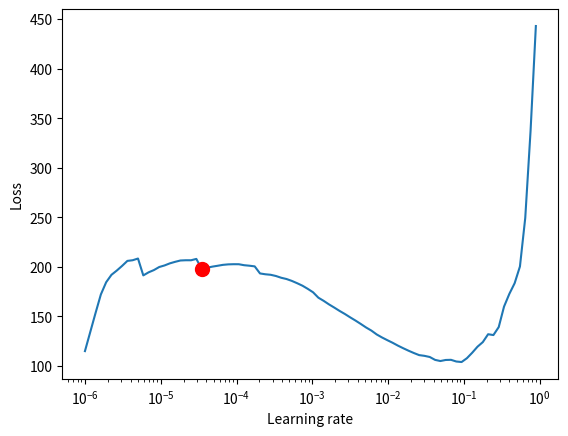

In [ ]:
cls_task = get_cls_task()
tuner_trainer = L.Trainer()
tuner = Tuner(tuner_trainer)
lr_finder = tuner.lr_find(cls_task, datamodule=cls_data, max_lr=10, min_lr=1e-6, num_training=100, mode = "exponential")
# print(lr_finder.results)
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
new_lr, cls_task.hparams.learning_rate

这个方法我认为也可以用于调整weight decay。

In [ ]:
cls_task = get_cls_task()
cls_task.hparams.learning_rate = new_lr
tuner_trainer = L.Trainer()
tuner = Tuner(tuner_trainer)
weight_decay_finder = tuner.lr_find(cls_task, datamodule=cls_data, max_lr=1e-3, min_lr=1e-5, num_training=50, attr_name='weight_decay')

INFO: Seed set to 0


Sat 2024-11-16 00:54:03.777345

INFO     Seed set to 0                                                                                   ]8;id=942500;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=891786;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#57\57]8;;\

INFO: Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Sat 2024-11-16 00:54:03.800328

INFO     Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook   ]8;id=441001;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=42450;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside                
         interactive / notebook environments is considered experimental and unstable. Your mileage                 
         may vary.                                                                                                 

INFO: GPU available: True (cuda), used: True


Sat 2024-11-16 00:54:03.836096

INFO     GPU available: True (cuda), used: True                                                     ]8;id=962838;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=821872;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


Sat 2024-11-16 00:54:03.852469

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=611720;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=934973;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


Sat 2024-11-16 00:54:03.868754

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=295528;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=146534;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:54:03.892937

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=262674;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=953938;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Finding best initial lr:   0%|          | 0/50 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=50` reached.


Sat 2024-11-16 00:54:11.843827

INFO     `Trainer.fit` stopped: `max_steps=50` reached.                                             ]8;id=945989;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=154100;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Learning rate set to 7.585775750291839e-05


Sat 2024-11-16 00:54:11.865877

INFO     Learning rate set to 7.585775750291839e-05                                                ]8;id=942500;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py\lr_finder.py]8;;\:]8;id=891786;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py#301\301]8;;\

INFO: Restoring states from the checkpoint path at /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/coding_projects/P2_SVM/.lr_find_c0a44246-c85b-407a-8dae-440075c5ae1a.ckpt


Sat 2024-11-16 00:54:11.877609

INFO     Restoring states from the checkpoint path at                                               ]8;id=105592;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=370977;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/                
         coding_projects/P2_SVM/.lr_find_c0a44246-c85b-407a-8dae-440075c5ae1a.ckpt                                 

INFO: Restored all states from the checkpoint at /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/coding_projects/P2_SVM/.lr_find_c0a44246-c85b-407a-8dae-440075c5ae1a.ckpt


Sat 2024-11-16 00:54:11.900391

INFO     Restored all states from the checkpoint at                                                 ]8;id=957361;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=214410;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/notebooks/                
         coding_projects/P2_SVM/.lr_find_c0a44246-c85b-407a-8dae-440075c5ae1a.ckpt                                 

(7.585775750291839e-05, 7.585775750291839e-05)

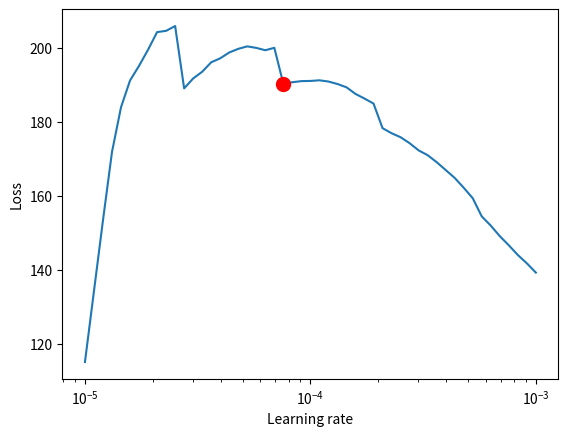

In [ ]:
fig = weight_decay_finder.plot(suggest=True)
fig.show()
new_weight_decay = weight_decay_finder.suggestion()
new_weight_decay, cls_task.hparams.weight_decay

由于代码限制，第二张图中显示的learning rate其实是weight decay。

现在我们对调整后的参数进行重新训练

In [ ]:
cls_task = get_cls_task()
cls_task.hparams.learning_rate = new_lr
cls_task.hparams.weight_decay = new_weight_decay

INFO: Seed set to 0


Sat 2024-11-16 00:54:57.243884

INFO     Seed set to 0                                                                                   ]8;id=945989;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=154100;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#57\57]8;;\

In [ ]:
trainer.fit(cls_task, datamodule=cls_data)
val_res_tuned = trainer.validate(cls_task, datamodule=cls_data)
test_res_tuned = trainer.test(cls_task, datamodule=cls_data)
pass

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/ye_canming/repos/assignments/THU-Coursework-Machine-Learning-for-Big-Data/runs/lightning_logs/version_16/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:58:01.204967

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=495077;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=587007;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

INFO: 
  | Name    | Type                | Params | Mode  | In sizes | Out sizes
-------------------------------------------------------------------------------
0 | model   | Linear              | 650    | train | [1, 64]  | [1, 10]  
1 | loss_fn | MultiClassHingeLoss | 0      | train | ?        | ?        
-------------------------------------------------------------------------------
650       Trainable params
0         Non-trainable params
650       Total params
0.003     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sat 2024-11-16 00:58:01.224387

INFO                                                                                           ]8;id=640561;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=671532;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
           | Name    | Type                | Params | Mode  | In sizes | Out sizes                                 
         -------------------------------------------------------------------------------                           
         0 | model   | Linear              | 650    | train | [1, 64]  | [1, 10]                                   
         1 | loss_fn | MultiClassHingeLoss | 0      | train | ?        | ?                                         
         -------------------------------------------------------------------------------                           
         650       Trainable params                                                                                
         0         Non-trainable params                                                                            
         650       Total params                                                                                    
         0.003     Total estimated model params size (MB)                                                          
         2         Modules in train mode                                                                           
         0         Modules in eval mode                                                                            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (11) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:58:03.645924

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=464197;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=907343;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_acc1          │    0.1319444477558136     │
│         val_acc10         │            1.0            │
│         val_acc2          │    0.2361111044883728     │
│         val_acc20         │            1.0            │
│         val_acc3          │    0.3541666567325592     │
│         val_acc5          │    0.5347222089767456     │
│   val_balanced_accuracy   │    0.13571429252624512    │
│      val_cohen_kappa      │    0.03511122986674309    │
│          val_f1           │    0.1358683854341507     │
│      val_hinge_loss       │    1.1006195545196533     │
│       val_log_loss        │    2.3971312046051025     │
│         val_loss          │    204.75518798828125     │
│   val_matthews_corrcoef   │    0.03540673106908798    │
│       val_precision       │    0.13904762268066406    │
│        val_recall         │    0.13571429252624512    │
│        val_roc_auc        │     0.544339656829834     │
└───────────────────────────┴───────────────────────────┘

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Sat 2024-11-16 00:58:04.947243

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=963080;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=575352;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc1         │    0.11666666716337204    │
│        test_acc10         │            1.0            │
│         test_acc2         │    0.25555557012557983    │
│        test_acc20         │            1.0            │
│         test_acc3         │    0.3444444537162781     │
│         test_acc5         │    0.5166666507720947     │
│  test_balanced_accuracy   │    0.11671385914087296    │
│     test_cohen_kappa      │   0.018240757286548615    │
│          test_f1          │    0.1174597293138504     │
│      test_hinge_loss      │    1.1020585298538208     │
│       test_log_loss       │     2.420191526412964     │
│         test_loss         │     219.2089385986328     │
│  test_matthews_corrcoef   │   0.018393170088529587    │
│      test_precision       │    0.12187045812606812    │
│        test_recall        │    0.11671385914087296    │
│       test_roc_auc        │    0.5245167016983032     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
val_res = val_res[0]
test_res = test_res[0]
val_res_tuned = val_res_tuned[0]
test_res_tuned = test_res_tuned[0]

In [ ]:
results = []
for key in val_res.keys():
    delta = val_res_tuned[key] - val_res[key]
    is_better = delta>0 
    if 'loss' in key:
        is_better = not is_better
    results.append(dict(metric=key, value=val_res[key], tuned_value=val_res_tuned[key], delta=delta, is_better=is_better))
for key in test_res.keys():
    delta = test_res_tuned[key] - test_res[key]
    is_better = delta>0 
    if 'loss' in key:
        is_better = not is_better
    results.append(dict(metric=key, value=test_res[key], tuned_value=test_res_tuned[key], delta=delta, is_better=is_better))

In [ ]:
pd.DataFrame(results)

,metric,value,tuned_value,delta,is_better
0,val_loss,263.031586,204.755188,-58.276398,True
1,val_acc1,0.854167,0.131944,-0.722222,False
2,val_acc2,0.951389,0.236111,-0.715278,False
3,val_acc3,0.965278,0.354167,-0.611111,False
4,val_acc5,0.979167,0.534722,-0.444444,False
5,val_acc10,1.000000,1.000000,0.000000,False
6,val_acc20,1.000000,1.000000,0.000000,False
7,val_matthews_corrcoef,0.842790,0.035407,-0.807383,False
8,val_f1,0.854586,0.135868,-0.718718,False
9,val_precision,0.883516,0.139048,-0.744469,False


我们发现其实 `test_loss` 与 `val_loss` 其实我们调参之后的模型确实变小了，说明了调参的有效性。

但是其他所有指标，包括sklearn里面的`hinge_loss` (one vs all, 不是 crammer_singer，并且有对样本平均) 都变差了。这说明 crammer_singer 方法，或者"sum"而非"mean“的损失函数，是带有一定局限性的。

### 附加题: 对比不同 kernel 方法下的 SVM 分类器 （对完整SVM进行调参）

现在我们手动实现了线性SVM，接下来我们对比不同 kernel 方法下的 SVM 分类器。

接下来的内容请见文件 [03svm_kernel_hpo](./03svm_kernel_hpo.html)。

本次Project的目录请见绪论 [00svm](./00svm.html)。

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()